In [98]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [22]:
import torch
import torch.nn.functional as F
from torch import Tensor

In [15]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [82]:
def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
      context = [0] * block_size
      for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)

          context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [150]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [151]:
sum(p.nelement() for p in parameters)

11897

In [152]:
for p in parameters:
    p.requires_grad = True

In [153]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [154]:
lri = []
lossi = []
stepi = []

In [158]:
def train(X, Y, parameters, batch_size=32, iterations=250000):
  for i in range(iterations):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # forward pass
    emb = parameters[0][X[ix]]
    h = torch.tanh(emb.view(-1, 30) @ parameters[1] + parameters[2])
    logits = h @ parameters[3] + parameters[4]
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # update weights
    # lr = lrs[i]
    lr = 0.1
    if(i > iterations / 2):
      lr = 0.01
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
  return parameters

In [156]:
def stats_plot(stepi, lossi):
    plt.plot(stepi, lossi)

In [161]:
def benchmark(x,y, parameters):
    emb = parameters[0][x]
    h = torch.tanh(emb.view(-1, 30) @ parameters[1] + parameters[2])
    logits = h @ parameters[3] + parameters[4]
    loss = F.cross_entropy(logits, y)
    print(loss)
    return loss

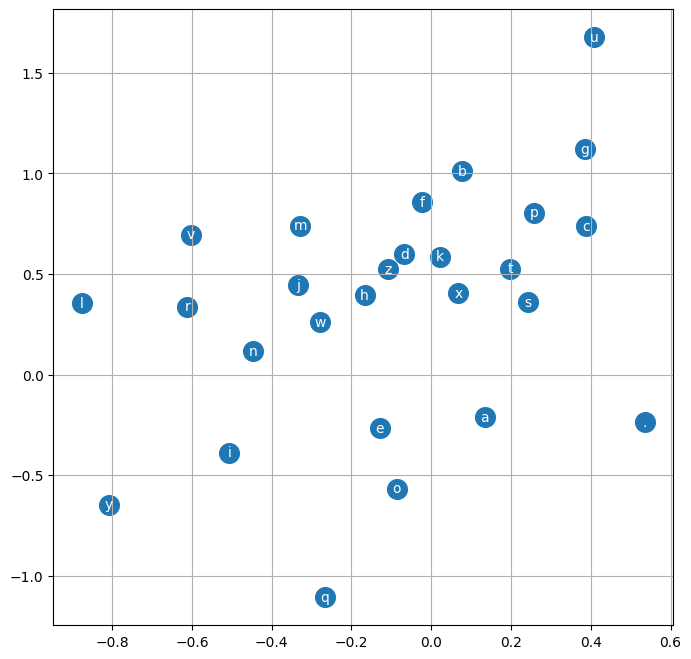

In [115]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [159]:
def predict(parameters, count=10):
    for i in range(count):
        out = []
        context = [0] * block_size
        while True:
            emb = parameters[0][torch.tensor([context])]
            h = torch.tanh(emb.view(1, -1) @ parameters[1] + parameters[2])
            logits = h @ parameters[3] + parameters[4]
            p = F.softmax(logits, dim=1)

            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix]
            if(ix == 0):
                break
            out.append(ix)
        print(''.join(itos[i] for i in out))

In [160]:
train(Xtr, Ytr, parameters, 64)

[tensor([[ 1.8497e+00,  6.3741e-01,  1.8928e-01, -7.3406e-01,  6.5976e-01,
          -2.1963e-01, -1.8566e+00,  8.3005e-01,  2.7067e-01,  1.2777e+00],
         [ 2.3314e-01,  7.1136e-01, -5.5476e-01, -2.5405e-01,  1.0631e+00,
           2.9984e+00,  1.1683e+00, -9.6961e-01,  8.4399e-01, -1.2892e+00],
         [ 6.3153e-01,  2.2633e-01, -1.2197e+00, -4.1390e-01, -3.1450e-01,
           1.1603e+00,  1.1701e+00,  4.3394e-01,  1.4115e-04, -2.0775e-01],
         [-2.1185e-01,  3.1134e-01,  1.6642e-01, -2.7011e-01, -1.5828e+00,
          -2.7196e-01, -1.2393e+00,  4.9656e-01, -4.9179e-01,  1.5909e-01],
         [ 2.8476e-01,  8.1108e-02, -5.9743e-01,  3.3014e-01, -4.2617e-01,
           8.6934e-01,  8.5916e-01,  1.3791e-02, -2.0198e-01, -2.9865e-01],
         [-3.6151e-01,  4.1416e-01, -1.6635e-02, -8.9387e-01, -2.4019e-01,
           1.6544e-01,  7.6879e-01, -5.4016e-01, -8.0039e-01,  1.2455e-01],
         [ 2.5687e-01, -7.8727e-01, -1.9596e+00, -1.1761e+00,  6.6338e-01,
          -4.5800e-

In [162]:
benchmark(Xtr, Ytr, parameters)
benchmark(Xdev, Ydev, parameters)

tensor(2.1015, grad_fn=<NllLossBackward0>)
tensor(2.1510, grad_fn=<NllLossBackward0>)


tensor(2.1510, grad_fn=<NllLossBackward0>)

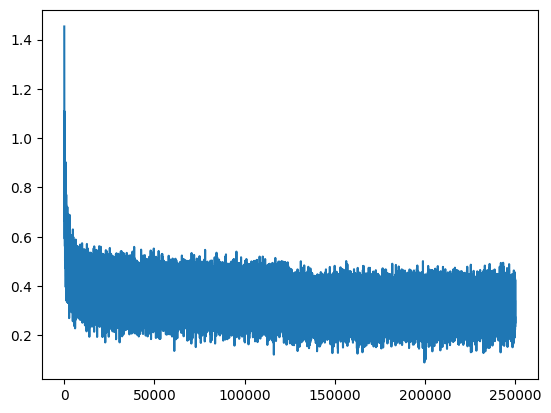

In [164]:
stats_plot(stepi, lossi)

In [165]:
predict(parameters, 10)

sir
giely
kit
abyonny
eluna
szaymerion
nivanne
malaser
leigh
dussa
